# Beta Variational Autoencoder Using Keras data Dsprites

The code is based on the book [Generative Deep Learning by David Foster](https://www.oreilly.com/library/view/generative-deep-learning/9781492041931/).

## Data

The data is taken from [Dsprites dataset](https://github.com/deepmind/dsprites-dataset). 

For loading the dataset we used this [notebook](https://github.com/deepmind/dsprites-dataset/blob/master/dsprites_reloading_example.ipynb).

The datafiles are on the input folder.

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import os

# Change figure aesthetics
%matplotlib inline
sns.set_context('paper', font_scale=1.2, rc={'lines.linewidth': 1.5})

In [4]:
path = os.getcwd()
dataset_zip = np.load(path+'/input/dsprites/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'
                     ,encoding='bytes', allow_pickle=True)

print('Keys in the dataset:', dataset_zip.keys())
imgs = dataset_zip['imgs']
latents_values = dataset_zip['latents_values']
latents_classes = dataset_zip['latents_classes']
metadata = dataset_zip['metadata'][()]


Keys in the dataset: KeysView(<numpy.lib.npyio.NpzFile object at 0x7fae4a97cc18>)


### Description of the dataset

From the metadata we have the description of the dataset and how it was generated:

    'Disentanglement test Sprites dataset.Procedurally generated 2D shapes, from 6 disentangled latent factors.This dataset uses 6 latents, controlling the color, shape, scale, rotation and position of a sprite. All possible variations of the latents are present. Ordering along dimension 1 is fixed and can be mapped back to the exact latent values that generated that image.We made sure that the pixel outputs are different. No noise added.'

The latent space size for generating the dataset is:

    - 'latents_sizes': array([ 1,  3,  6, 40, 32, 32]), 

Each latent affect only one attribute of the figure, the atributes are:

    - 'latents_names': ('color', 'shape', 'scale', 'orientation', 'posX', 'posY')
    
**Therefore, we have only one color, 3 shapes, 6 types of scales, 40 points regarding rotations, 32 points for the posX (or posY).**

In [0]:
# Define number of values per latents and functions to convert to indices
latents_sizes = metadata[b'latents_sizes']

latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:],
                                np.array([1,])))

### Helper Functions 

In [0]:
def latent_to_index(latents):    
    return np.dot(latents, latents_bases).astype(int)

def sample_latent_fix_shape(size=1,shape_index=0):
    """Sample the latent space fixing the 
    shape.
    
    Parameters:
    -----------------------------------------
    size(integer): Number of samples.
    shape_index(integer): Choose the shape that you want:
                          0: Square
                          1: Ellipse
                          2: Heart
                         (default=0)
    
    """
    
    samples = np.zeros((size, latents_sizes.size))
    
    for lat_i, lat_size in enumerate(latents_sizes):
        samples[:, lat_i] = np.random.randint(lat_size, size=size)
    
    samples[:,1] = shape_index
    return samples

def sample_latent_changing_x_y(size=1):
    """Sample the latent space changing only the position.
    
    Parameters:
    -----------------------------------------
    size(integer): Number of samples.
    
    """
    
    
    samples = np.zeros((size, latents_sizes.size))
    
    
    for lat_i, lat_size in enumerate(latents_sizes):                
        if lat_i in range(len(latents_sizes)-2):
            samples[:, lat_i] = 0
        else:
            samples[:, lat_i] = np.random.randint(lat_size, size=size)        
    
    return samples


def sample_latent(size=1):
    """Sample the latent space.
    
    Parameters:
    -----------------------------------------
    size(integer): Number of samples.
    
    """
    
    samples = np.zeros((size, latents_sizes.size))
    
    for lat_i, lat_size in enumerate(latents_sizes):
        samples[:, lat_i] = np.random.randint(lat_size, size=size)
        
    return samples

In [0]:
# Sample latents randomly 
latents_sampled = sample_latent_changing_x_y(size=5000)

# Select images
indices_sampled = latent_to_index(latents_sampled)


# imgs_sampled = imgs[indices_sampled]
x_test = imgs[indices_sampled]
x_test = x_test.reshape(x_test.shape + (1,))

In [0]:
# Sample latents randomly
latents_sampled_train = sample_latent_changing_x_y(size=30000)

# Select images
indices_sampled = latent_to_index(latents_sampled_train)

# Select images
indices_sampled_train = latent_to_index(latents_sampled_train)
imgs_sampled = imgs[indices_sampled]

x_train = imgs[indices_sampled_train]
x_train = x_train.reshape(x_train.shape + (1,))

In [9]:
print('Analysing the shapes:\n'+ 
      ' X train shape: {} \n X test shape: {} \n'.format(x_train.shape,                                                                               
                                                                               x_test.shape))

Analysing the shapes:
 X train shape: (30000, 64, 64, 1) 
 X test shape: (5000, 64, 64, 1) 



## Building the Beta-VAE

*In this notebook I will ignore Furure and Deprecation Warnings*

**Choose 'build' if you want to train the VAE, if you want to reload weights type 'reconstruct'.**

In [10]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

from Models.VAE_Keras import VariationalAutoencoder_Keras

Using TensorFlow backend.


In [0]:
# run params

SECTION = 'bvae'
RUN_ID = '0001'
DATA_NAME = 'Dsprites_XY'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode = 'build'

In [0]:
#Latent size
ZDIM = 2

bvae = VariationalAutoencoder_Keras(   
      input_dim = (64,64,1)
    , encoder_conv_filters = [32,64,64,64]#, 64]
    , encoder_conv_kernel_size = [3,3,3,3]#,3]
    , encoder_conv_strides = [1,2,2,1]#,1]
    , decoder_conv_t_filters = [64,64,32,1]
    , decoder_conv_t_kernel_size = [3,3,3,3]
    , decoder_conv_t_strides = [1,2,2,1]
    , z_dim = ZDIM
)

if mode == 'build':
    bvae.save(RUN_FOLDER)
else:
    bvae.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

### Beta-VAE Summary

In [13]:
bvae.encoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 64, 64, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 64, 64, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 32, 32, 64)   18496       leaky_re_lu_1[0][0]              
____________________________________________________________________________________________

In [14]:
bvae.decoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 16384)             49152     
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 64)        0         
_________________________________________________________________
decoder_conv_t_0 (Conv2DTran (None, 16, 16, 64)        36928     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
decoder_conv_t_1 (Conv2DTran (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 64)        0   

## Training

In [0]:
#Compile Parameters (These parameters depend on a fine tuning) 

LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 5000
BETA = 10

In [0]:
bvae.compile(LEARNING_RATE, R_LOSS_FACTOR, BETA)

In [0]:
# Training Parameters

BATCH_SIZE = 126

EPOCHS = 20

PRINT_EVERY_N_BATCHES = 100

INITIAL_EPOCH = 0

In [0]:
bvae.train(     
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , initial_epoch = INITIAL_EPOCH
          )

## Analysis

### Sampling from the Latent Space

Here we want to sample the latent space randomly in order to see if the VAE can generate images. 

Let's sample coordinates 1 and 2 on the latent space randomly.

In [21]:
print(f"Size of the latent space: {ZDIM}")

Size of the latent space: 2


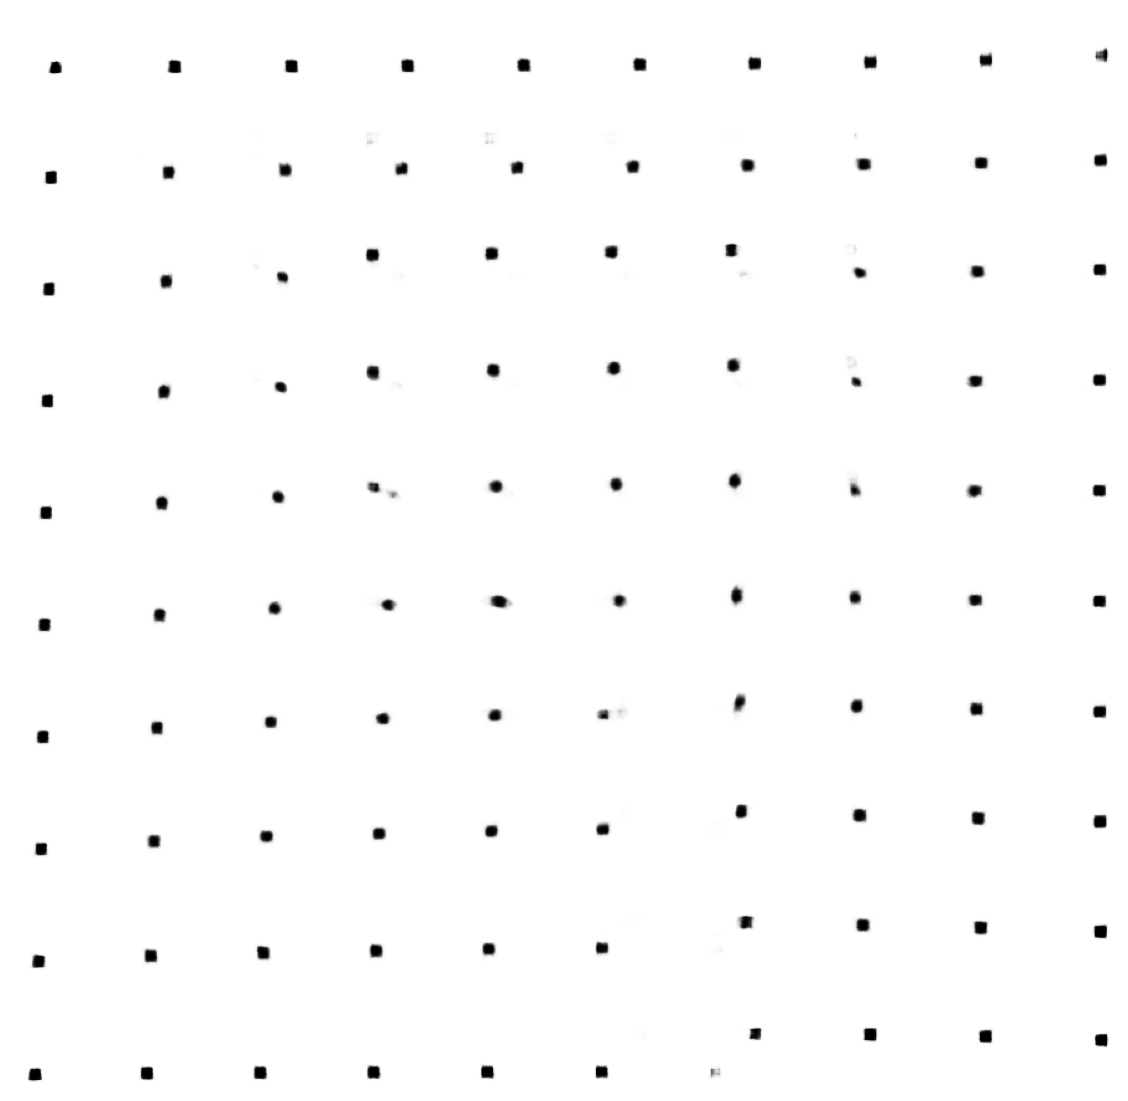

In [29]:
from scipy.stats import norm

grid_size = 10
figsize = 20

x = norm.ppf(np.linspace(0.01, 0.99, grid_size))
y = norm.ppf(np.linspace(0.01, 0.99, grid_size))

xv, yv = np.meshgrid(x, y)

xv = xv.flatten()
yv = yv.flatten()

z_grid = np.array(list(zip(xv, yv)))

reconst = bvae.decoder.predict(z_grid)


fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')